Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['d_pi', 'EUR_NOK', 'dI_t', 'Q']

[info] Walk-forward VAR (daily macro panel) – Quarterly
       Periods       : 2000Q1 → 2025Q4 | n=104
       min_hist_days : 400
       max_var_lags  : 10
       n_jobs_outer  : -1, backend=loky

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter
  2000Q2: hist<400
  2000Q3: hist<400
  2000Q4: hist<400
  2001Q1: hist<400

=== VAR (daily macro panel) – Quarterly EUR/NOK performance ===
Observations: 99
RMSE (level): 0.235289
MAE  (level): 0.170731
Directional accuracy: 68/98 (69.4%)

=== Diebold–Mariano vs Random Walk (VAR daily macro panel, quarterly) ===
Loss: MSE | horizon h=1
DM-statistic: -0.1858
p-value     : 0.8526


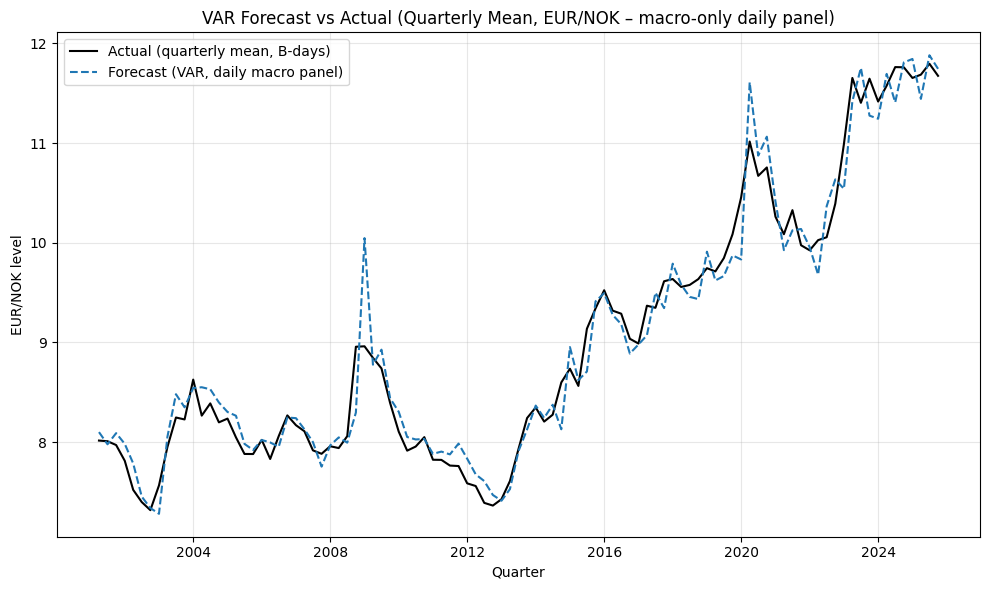

Saved: VAR_Q_daily_macro_panel.png
Saved: VAR_Q_daily_macro_panel.pdf


In [ ]:
# =========================================
# VAR_Fx-Quarterly_macro_dailyVAR
# =========================================
# Panel VAR – EUR/NOK walk-forward (quarterly, levels)
# Daily panel, macro-only version:
#
#   - Target / endogenous block:
#       EUR_NOK, Q, d_pi, dI_t
#
#   - Data: daily calendar days, forward-filled
#   - Cut: last business day of previous quarter (based on EUR_NOK business days)
#   - Forecast: recursive daily next-quarter using VAR
#       -> aggregate EUR/NOK to quarterly mean over business days
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed)
#   - PARALLEL OUTER LOOP over quarters
# =========================================

!pip -q install pandas numpy matplotlib requests certifi statsmodels scikit-learn joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"       # Quarterly evaluation, calendar quarters ending in Dec
    min_hist_days: int = 400    # Minimum daily history before first VAR estimation
    max_var_lags: int = 10      # Max daily VAR lag order (tune if needed)
    max_horizon: int = 128      # Must exceed longest quarter (~92 days)

    # Parallel settings
    n_jobs_outer: int = -1      # -1 = all cores
    backend: str = "loky"       # separate processes (safe for statsmodels)

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "VAR_Q_daily_macro_panel.png"
    fig_pdf: str = "VAR_Q_daily_macro_panel.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]

# Endogenous block: FX + macro only
ENDOG_SERIES = [TARGET_SERIES] + MACRO_COLS   # ["EUR_NOK", "Q", "d_pi", "dI_t"]
ALL_COLS = ENDOG_SERIES


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily DF + EUR_NOK business-day series
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV. Expected columns:
      Date, EUR_NOK, Q, d_pi, dI_t

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cuts and quarterly ground truth)
      DF_d : daily (D) wide DataFrame with ENDOG_SERIES,
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date"} | set(ENDOG_SERIES)
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    for col in ENDOG_SERIES:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK (truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# VAR lag order selection (daily)
# -----------------------------
def select_var_lag(df_hist: pd.DataFrame, max_lags: int) -> int:
    """
    Select daily VAR lag order using information criteria (AIC/BIC/HQ/FPE).

    Returns a lag p between 1 and max_lags.
    """
    p = 1
    try:
        model = VAR(df_hist)
        order_res = model.select_order(maxlags=max_lags)
        # Try to use AIC, then BIC, HQIC, FPE
        for crit in ["aic", "bic", "hqic", "fpe"]:
            val = order_res.selected_orders.get(crit)
            if val is not None:
                p = int(val)
                break
    except Exception as e:
        print(f"[warning] VAR lag selection failed, fallback to p=1: {e}")

    p = max(1, min(p, max_lags, len(df_hist) - 1))
    return p


# -----------------------------
# Quarterly walk-forward using daily VAR
# PARALLEL outer loop
# -----------------------------
def walk_forward_var_quarterly_daily_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky",
) -> pd.DataFrame:
    """
    For each calendar quarter q:
      - cut at last business day of previous quarter
      - fit VAR on daily history up to cut (ENDOG_SERIES = EUR_NOK + macro)
      - recursively forecast full next quarter at daily frequency (H calendar days)
      - aggregate EUR/NOK forecast to business-day quarterly mean and compare to truth
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    if CFG.verbose:
        print(f"\n[info] Walk-forward VAR (daily macro panel) – Quarterly")
        print(f"       Periods       : {quarters[0]} → {quarters[-1]} | n={len(quarters)}")
        print(f"       min_hist_days : {CFG.min_hist_days}")
        print(f"       max_var_lags  : {CFG.max_var_lags}")
        print(f"       n_jobs_outer  : {n_jobs_outer}, backend={backend}")

    def _process_one_quarter(q: pd.Period):
        """
        Inner worker: process one calendar quarter q.
        Returns:
          (quarter_str, row_dict_or_None, reason_or_None)
        """
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        # 1) Cut = last business day of previous quarter
        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(q), None, "no_cut_in_prev_quarter")

        # 2) Daily history up to cut (EUR_NOK + macro only)
        hist_df = DF_d.loc[:cut, ENDOG_SERIES].copy()
        if hist_df.shape[0] < CFG.min_hist_days:
            return (str(q), None, f"hist<{CFG.min_hist_days}")

        # 3) Business days inside target quarter (truth + aggregation base)
        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            return (str(q), None, "no_bdays_in_quarter")
        y_true = float(S_b.loc[idx_q_b].mean())

        # 4) Horizon = full calendar quarter length (inclusive) in calendar days
        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            return (str(q), None, f"horizon_invalid(H={H})")

        # 5) Fit daily VAR and forecast H-step-ahead macro panel
        try:
            p = select_var_lag(hist_df, max_lags=CFG.max_var_lags)
            model = VAR(hist_df)
            res = model.fit(p)

            # Initial state = last p daily observations
            y0 = hist_df.values[-p:]
            y_fore = res.forecast(y0, steps=H)  # shape (H, k)
        except Exception as e:
            return (str(q), None, f"var_fit_fail({e})")

        # 6) Build forecast DataFrame for next-quarter daily path
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fore = pd.DataFrame(y_fore, index=f_idx, columns=hist_df.columns)

        # 7) Extract EUR_NOK forecast and aggregate to business-day mean
        pred_daily = df_fore[TARGET_SERIES]
        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            return (str(q), None, "no_overlap_pred_B_days")

        y_pred = float(pred_b.dropna().mean())

        row = {
            "quarter": q,
            "cut": cut,
            "lag_order": p,
            "y_true": y_true,
            "y_pred": y_pred,
        }
        return (str(q), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_quarter)(q) for q in quarters
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if str(q) not in rows]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df


# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy (quarterly EUR/NOK)."""
    df = eval_df.copy()
    if df.empty:
        print("\nNo evaluation data.")
        return df

    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== VAR (daily macro panel) – Quarterly EUR/NOK performance ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark = previous quarter's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (VAR daily macro panel, quarterly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_quarterly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (quarterly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (quarterly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"], color="tab:blue", linestyle="--",
        label="Forecast (VAR, daily macro panel)"
    )

    plt.title("VAR Forecast vs Actual (Quarterly Mean, EUR/NOK – macro-only daily panel)")
    plt.xlabel("Quarter")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data (aligned with GB quarterly code, macro-only VAR panel)
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Quarterly walk-forward and evaluation (parallel outer loop)
    df_eval = walk_forward_var_quarterly_daily_parallel(
        S_b, DF_d,
        n_jobs_outer=CFG.n_jobs_outer,
        backend=CFG.backend,
    )
    eval_df = evaluate(df_eval)

    # 3) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 4) Plot
    plot_quarterly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

    return {
        "S_b": S_b,
        "DF_d": DF_d,
        "eval_quarterly": eval_df,
    }


if __name__ == "__main__":
    results = main()
